# **Import**

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

# **Data Load**

In [3]:
cd /content/drive/MyDrive/[Projects]/Kaggle/NASA 터보팬 제트 엔진의 잔존 수명 예측 및 예지보전 방안/Data

/content/drive/MyDrive/[Projects]/Kaggle/NASA 터보팬 제트 엔진의 잔존 수명 예측 및 예지보전 방안/Data


In [4]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = [f's_{i + 1}' for i in range(21)]
col_names = index_names + setting_names + sensor_names

train_df = pd.read_csv('./train_FD003.csv')

In [5]:
max_cycle = train_df.groupby('unit_number')['time_cycles'].max().reset_index()
max_cycle.columns = ['unit_number', 'max_cycle']

train_df = train_df.merge(max_cycle, on='unit_number', how='left')

train_df['RUL'] = train_df['max_cycle'] - train_df['time_cycles']

# **Model**

In [6]:
features = [
    'unit_number', 'time_cycles',
    's_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_10', 's_11',
    's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21', 'RUL'
]
train_df = train_df[features]
train_df.head()

,unit_number,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL
0,1,1,642.36,1583.23,1396.84,553.97,2387.96,9062.17,1.3,47.30,522.31,2388.01,8145.32,8.4246,391,39.11,23.3537,258
1,1,2,642.50,1584.69,1396.89,554.55,2388.00,9061.78,1.3,47.23,522.42,2388.03,8152.85,8.4403,392,38.99,23.4491,257
2,1,3,642.18,1582.35,1405.61,554.43,2388.03,9070.23,1.3,47.22,522.03,2388.00,8150.17,8.3901,391,38.85,23.3669,256
3,1,4,642.92,1585.61,1392.27,555.21,2388.00,9064.57,1.3,47.24,522.49,2388.08,8146.56,8.3878,392,38.96,23.2951,255
4,1,5,641.68,1588.63,1397.65,554.74,2388.04,9076.14,1.3,47.15,522.58,2388.03,8147.80,8.3869,392,39.14,23.4583,254


In [7]:
agg_features = []
using_sensor = [
    's_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_10', 's_11',
    's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21'
]

for unit in train_df['unit_number'].unique():
    unit_data = train_df[train_df['unit_number'] == unit]
    for t in range(2, len(unit_data)+1):  # 최소 2개 시점부터
        sub_data = unit_data.iloc[:t]  # 1~t
        features = {'unit_number': unit, 'time_cycles': sub_data['time_cycles'].iloc[-1]}

        for sensor in using_sensor:
            features[f'{sensor}_mean'] = sub_data[sensor].mean()
            features[f'{sensor}_std'] = sub_data[sensor].std()
            features[f'{sensor}_min'] = sub_data[sensor].min()
            features[f'{sensor}_max'] = sub_data[sensor].max()
            features[f'{sensor}_last'] = sub_data[sensor].iloc[-1]
            features[f'{sensor}_median'] = sub_data[sensor].median()
            # trend는 최소 2개 이상 시점에서만 계산 가능
            features[f'{sensor}_trend'] = np.polyfit(sub_data['time_cycles'], sub_data[sensor], 1)[0]

        # RUL은 해당 시점에서 남은 수명
        features['RUL'] = sub_data['RUL'].iloc[-1]

        agg_features.append(features)

agg_df = pd.DataFrame(agg_features)

In [8]:
agg_df.head()

,unit_number,time_cycles,s_2_mean,s_2_std,s_2_min,s_2_max,s_2_last,s_2_median,s_2_trend,s_3_mean,...,s_20_median,s_20_trend,s_21_mean,s_21_std,s_21_min,s_21_max,s_21_last,s_21_median,s_21_trend,RUL
0,1,2,642.430000,0.098995,642.36,642.50,642.50,642.43,0.140000,1583.960000,...,39.050,-0.120000,23.401400,0.067458,23.3537,23.4491,23.4491,23.4014,0.095400,257
1,1,3,642.346667,0.160416,642.18,642.50,642.18,642.36,-0.090000,1583.423333,...,38.990,-0.130000,23.389900,0.051692,23.3537,23.4491,23.3669,23.3669,0.006600,256
2,1,4,642.490000,0.315172,642.18,642.92,642.92,642.43,0.136000,1583.970000,...,38.975,-0.059000,23.366200,0.063467,23.2951,23.4491,23.2951,23.3603,-0.025800,255
3,1,5,642.328000,0.453564,641.68,642.92,641.68,642.36,-0.094000,1584.902000,...,38.990,0.003000,23.384620,0.068685,23.2951,23.4583,23.4583,23.3669,0.005520,254
4,1,6,642.313333,0.407267,641.68,642.92,642.24,642.30,-0.066286,1584.766667,...,38.975,-0.011143,23.391867,0.063946,23.2951,23.4583,23.4281,23.3975,0.009366,253


In [9]:
x = agg_df.drop(['unit_number','RUL'], axis=1)
y = agg_df['RUL']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

## **XGBoost**

In [10]:
xgb_model = XGBRegressor(n_estimators=500, max_depth=6, learning_rate=0.05)
xgb_model.fit(x_train, y_train)
xgb_pred = xgb_model.predict(x_val)

In [11]:
xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_pred))
xgb_mae = mean_absolute_error(y_val, xgb_pred)

print(f"RMSE: {xgb_rmse:.3f}, MAE: {xgb_mae:.3f}")

RMSE: 7.018, MAE: 3.779


## **LightGBM**

In [12]:
lgb_model = LGBMRegressor(n_estimators=500, max_depth=6, learning_rate=0.05, verbose=-1)
lgb_model.fit(x_train, y_train)
lgb_pred = lgb_model.predict(x_val)

In [13]:
lgb_rmse = np.sqrt(mean_squared_error(y_val, lgb_pred))
lgb_mae = mean_absolute_error(y_val, lgb_pred)

print(f"RMSE: {lgb_rmse:.3f}, MAE: {lgb_mae:.3f}")

RMSE: 7.656, MAE: 4.401


# **Predict RUL**

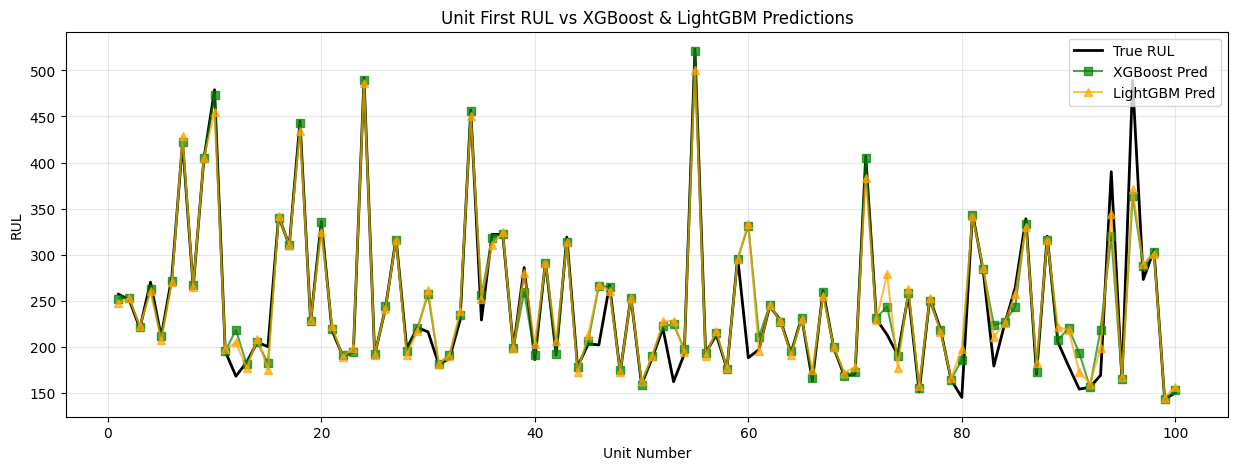

In [14]:
unit_ids = agg_df['unit_number'].unique()
rul_df = agg_df.groupby('unit_number')['RUL'].max().reset_index()

true_first_rul = []
xgb_first_pred = []
lgb_first_pred = []

for unit in unit_ids:
    unit_rows = agg_df[agg_df['unit_number'] == unit]
    first_idx = unit_rows.index[0]

    true_first_rul.append(rul_df.loc[unit-1, 'RUL'])  # test set일 경우 RUL_FD001.csv 사용
    xgb_first_pred.append(xgb_model.predict(unit_rows.drop(['unit_number','RUL'], axis=1).iloc[[0]])[0])
    lgb_first_pred.append(lgb_model.predict(unit_rows.drop(['unit_number','RUL'], axis=1).iloc[[0]])[0])

df_compare = pd.DataFrame({
    'unit_number': unit_ids,
    'True_RUL': true_first_rul,
    'XGB_RUL': xgb_first_pred,
    'LGBM_RUL': lgb_first_pred
})

plt.figure(figsize=(15,5))
plt.plot(df_compare['unit_number'], df_compare['True_RUL'], label='True RUL', color='black', linewidth=2)
plt.plot(df_compare['unit_number'], df_compare['XGB_RUL'], label='XGBoost Pred', color='green', marker='s', alpha=0.7)
plt.plot(df_compare['unit_number'], df_compare['LGBM_RUL'], label='LightGBM Pred', color='orange', marker='^', alpha=0.7)

plt.xlabel('Unit Number')
plt.ylabel('RUL')
plt.title('Unit First RUL vs XGBoost & LightGBM Predictions')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# **Test**

In [15]:
test_df = pd.read_csv('./test_FD003.csv')
rul_df = pd.read_csv('./RUL_FD003.csv')

In [17]:
features = [
    'unit_number', 'time_cycles',
    's_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_10', 's_11',
    's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21'
]
test_df = test_df[features]
test_df.head()

,unit_number,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21
0,1,1,641.94,1581.93,1396.93,554.56,2387.93,9048.65,1.3,47.09,521.89,2387.94,8133.48,8.3760,391,39.07,23.4468
1,1,2,642.02,1584.86,1398.90,554.10,2387.94,9046.53,1.3,47.08,521.85,2388.01,8137.44,8.4062,391,39.04,23.4807
2,1,3,641.68,1581.78,1391.92,554.41,2387.97,9054.92,1.3,47.15,522.10,2387.94,8138.25,8.3553,391,39.10,23.4244
3,1,4,642.20,1584.53,1395.34,554.58,2387.94,9055.04,1.3,47.26,522.45,2387.96,8137.07,8.3709,392,38.97,23.4782
4,1,5,642.46,1589.03,1395.86,554.16,2388.01,9048.59,1.3,46.94,521.91,2387.97,8134.20,8.4146,391,39.09,23.3950


In [18]:
agg_features = []
using_sensor = [
    's_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_10', 's_11',
    's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21'
]

for unit in test_df['unit_number'].unique():
    unit_data = test_df[test_df['unit_number'] == unit]
    features = {'unit_number': unit, 'time_cycles': unit_data['time_cycles'].max()}

    for sensor in using_sensor:
        features[f'{sensor}_mean'] = unit_data[sensor].mean()
        features[f'{sensor}_std'] = unit_data[sensor].std()
        features[f'{sensor}_min'] = unit_data[sensor].min()
        features[f'{sensor}_max'] = unit_data[sensor].max()
        features[f'{sensor}_last'] = unit_data[sensor].iloc[-1]
        features[f'{sensor}_median'] = unit_data[sensor].median()
        features[f'{sensor}_trend'] = np.polyfit(unit_data['time_cycles'], unit_data[sensor], 1)[0]  # 선형 추세

    agg_features.append(features)

agg_df = pd.DataFrame(agg_features)

In [19]:
agg_df.head()

,unit_number,time_cycles,s_2_mean,s_2_std,s_2_min,s_2_max,s_2_last,s_2_median,s_2_trend,s_3_mean,...,s_20_last,s_20_median,s_20_trend,s_21_mean,s_21_std,s_21_min,s_21_max,s_21_last,s_21_median,s_21_trend
0,1,233,642.193391,0.370289,641.09,643.24,642.59,642.160,0.002385,1584.928112,...,39.43,39.100,0.000881,23.457124,0.072123,23.2847,23.6644,23.5679,23.45240,0.000531
1,2,124,642.542097,0.306953,641.83,643.28,642.56,642.540,0.003183,1588.658226,...,38.83,38.855,-0.001270,23.314119,0.068810,23.1469,23.4543,23.2821,23.31420,-0.000867
2,3,234,642.373932,0.316374,641.62,643.38,642.75,642.370,0.001725,1587.857863,...,39.27,39.210,0.001008,23.540120,0.072119,23.3762,23.7643,23.6440,23.53740,0.000543
3,4,68,642.554853,0.278270,641.86,643.28,642.28,642.535,0.002313,1589.098088,...,38.70,38.870,-0.001154,23.314722,0.058762,23.1968,23.4508,23.3804,23.30970,0.000406
4,5,138,642.053406,0.295584,641.36,642.81,642.15,642.085,-0.001090,1579.612609,...,38.89,38.870,0.001287,23.326915,0.081267,23.1570,23.5479,23.4463,23.31315,0.001237


In [20]:
x_test = agg_df.drop(['unit_number'], axis=1)
y_test = rul_df['RUL']

In [21]:
xgb_pred = xgb_model.predict(x_test)

xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_mae = mean_absolute_error(y_test, xgb_pred)

print(f"RMSE: {xgb_rmse:.3f}, MAE: {xgb_mae:.3f}")

RMSE: 29.918, MAE: 18.974


In [22]:
lgb_pred = lgb_model.predict(x_test)

lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_pred))
lgb_mae = mean_absolute_error(y_test, lgb_pred)

print(f"RMSE: {lgb_rmse:.3f}, MAE: {lgb_mae:.3f}")

RMSE: 28.685, MAE: 17.661


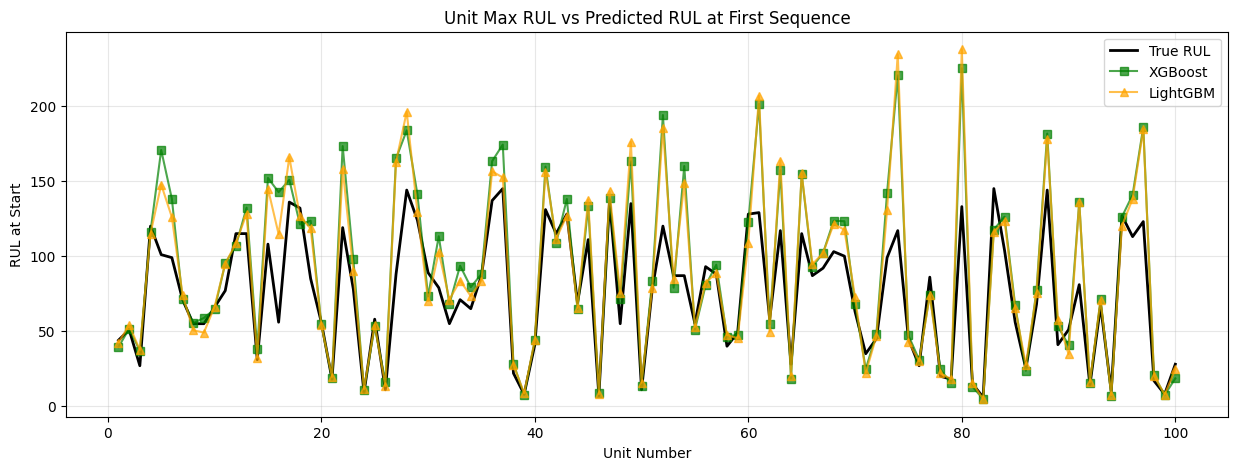

In [23]:
unit_ids = agg_df['unit_number']
true_max_rul = rul_df['RUL']

xgb_pred_full = xgb_model.predict(x_test)
lgb_pred_full = lgb_model.predict(x_test)

df_rul_compare = pd.DataFrame({
    'unit_number': unit_ids,
    'True_RUL': true_max_rul,
    'XGB_RUL': xgb_pred_full,
    'LGBM_RUL': lgb_pred_full
})

plt.figure(figsize=(15,5))
plt.plot(df_rul_compare['unit_number'], df_rul_compare['True_RUL'], label='True RUL', color='black', linewidth=2)
plt.plot(df_rul_compare['unit_number'], df_rul_compare['XGB_RUL'], label='XGBoost', color='green', marker='s', alpha=0.7)
plt.plot(df_rul_compare['unit_number'], df_rul_compare['LGBM_RUL'], label='LightGBM', color='orange', marker='^', alpha=0.7)

plt.xlabel('Unit Number')
plt.ylabel('RUL at Start')
plt.title('Unit Max RUL vs Predicted RUL at First Sequence')
plt.legend()
plt.grid(alpha=0.3)
plt.show()